In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from os import listdir
from os.path import isfile, join

/home/dc/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def compute_tvla(data_1, data_2, t_threshold=4.5, p_threshold=0.05):
    """
    Compute TVLA (Test Vector Leakage Assessment) statistics.
    
    Args:
        data_1: First dataset (n_samples, n_features)
        data_2: Second dataset (n_samples, n_features) or scalar for one-sample test
        flag_fr: Boolean flag for test type (True: independent samples, False: one-sample)
        t_threshold: Threshold for t-score significance (default: 4.5)
        p_threshold: Threshold for p-value significance (default: 0.05)
    
    Returns:
        tuple: (statistical_result, leaky_points, large_p_values)
    """

    if data_1.shape[1] != data_2.shape[1]:
        raise ValueError("Datasets must have same number of features")
    # print(f"\nData shapes: {data_1.shape}, {data_2.shape}")
    result = ss.ttest_ind(data_1, data_2, axis=0, equal_var=False)

    # Efficient NaN handling using numpy operations
    t_scores = result[0]
    p_values = result[1]
    
    # Replace NaN t-scores with 0
    t_scores = np.nan_to_num(t_scores, nan=0.0)
    
    # Count significant points
    leaky_points = np.sum(np.abs(t_scores) >= t_threshold)
    large_p_values = np.sum(p_values >= p_threshold)
    # Count how many leaky points have low p-value
    leaky_and_low_p = np.sum((np.abs(t_scores) >= t_threshold) & (p_values < p_threshold))
    
    print(f'T-scores above or below {t_threshold}: {leaky_points}\t\tLarge p-values: {large_p_values}') 
    print(f'Leaky points with low p-value: {leaky_and_low_p}')
    
    return (result, t_scores, leaky_points, large_p_values)

In [3]:
def plot_tvla(t_scores, N_traces, lower_bound, upper_bound, class_idx=None):
    if class_idx is not None:
        plot_file_path = 'tvla_plots/t_trace_train_test_spiking_activity_' + str(N_traces) + '_class_' + str(class_idx) + '.pdf'
    else:
        plot_file_path = 'tvla_plots/t_trace_train_test_spiking_activity_' + str(N_traces) + '.pdf'
    number_of_samples = len(t_scores)
    instruction_index = np.arange(0, number_of_samples)
    
    f = plt.figure(figsize=(30,6));
    font = {'weight': 'normal','size': 18}
    plt.tight_layout()
    plt.xlabel('Samples', fontdict=font)
    plt.ylabel('t-score', fontdict=font)
    plt.xticks(np.arange(lower_bound, upper_bound+1, int(number_of_samples/20)), fontsize=14);
    plt.yticks(fontsize=14);
    plt.plot(instruction_index, (t_scores) ,color='blue', alpha=0.5) #, label = 'All registers')
    plt.plot([lower_bound, upper_bound+1],[4.5, 4.5], '--r')
    plt.plot([lower_bound, upper_bound+1],[-4.5, -4.5], '--r')

    plt.grid()
    # plt.legend(loc='lower left', fontsize=18)
    if class_idx is not None:
        plt.title ('t-score for train-test spiking activity for N=' + str(N_traces) + ' and class ' + str(class_idx), fontdict=font)
    else:
        plt.title ('t-score for train-test spiking activity for N=' + str(N_traces), fontdict=font)
    plt.savefig(plot_file_path, bbox_inches = 'tight')

#### Load Spiking activity

In [4]:
# load spiking activity files
train_path = 'spikes_train/'
test_path = 'spikes_test/'
all_train_spikes = []
all_test_spikes = []
trainfiles = [f for f in listdir(train_path) if isfile(join(train_path, f))]
testfiles = [f for f in listdir(test_path) if isfile(join(test_path, f))]
# print("Train files: ", len(trainfiles), "Test files: ", len(testfiles))

In [5]:
df_train = pd.read_parquet(train_path + trainfiles[0])
df_test = pd.read_parquet(test_path + testfiles[0])
train_spikes = []
test_spikes = []
train_y_true = []
test_y_true = []
for trainfile in trainfiles[:5]:
    # print(trainfile)
    df_train = pd.read_parquet(train_path + trainfile)
    for i in range(df_train['spikes'].shape[0]):
        train_spikes.append(df_train['spikes'][i])
        train_y_true.append(df_train['y_true'][i])

print("test files")
for testfile in testfiles[:19]:
    # print(testfile)
    df_test = pd.read_parquet(test_path + testfile)
    for i in range(df_test['spikes'].shape[0]):
        test_spikes.append(df_test['spikes'][i])
        test_y_true.append(df_test['y_true'][i])

print(len(train_spikes), len(test_spikes))
print(len(train_y_true), len(test_y_true))

train_spikes = np.array(train_spikes)
test_spikes = np.array(test_spikes)
train_y_true = np.array(train_y_true)
test_y_true = np.array(test_y_true)

test files
1280 1130
1280 1130


In [6]:
# split train_spikes and test_spikes on the basis of y_true
train_spikes_class_idx = []
test_spikes_class_idx = []

for i in range(10):
    train_spikes_index = train_spikes[train_y_true == i]
    test_spikes_index = test_spikes[test_y_true == i]
    train_spikes_class_idx.append(train_spikes_index)
    test_spikes_class_idx.append(test_spikes_index)
    print(i, "train: ", train_spikes_index.shape, "\t test: ", test_spikes_index.shape)


0 train:  (140, 1146880) 	 test:  (120, 1146880)
1 train:  (140, 1146880) 	 test:  (113, 1146880)
2 train:  (129, 1146880) 	 test:  (110, 1146880)
3 train:  (137, 1146880) 	 test:  (112, 1146880)
4 train:  (129, 1146880) 	 test:  (110, 1146880)
5 train:  (116, 1146880) 	 test:  (102, 1146880)
6 train:  (121, 1146880) 	 test:  (109, 1146880)
7 train:  (121, 1146880) 	 test:  (128, 1146880)
8 train:  (121, 1146880) 	 test:  (112, 1146880)
9 train:  (126, 1146880) 	 test:  (114, 1146880)


##### Compute TVLA between train and test (class agnostic)

In [ ]:
N=1000
N_samples = train_spikes.shape[1]

all_t_scores = []
for i in range((N_samples//10000)+1):
    result, t_scores, leaky_points, large_p_values = compute_tvla(train_spikes[:N,i*10000:(i+1)*10000], test_spikes[:N,i*10000:(i+1)*10000])
    # print("t_scores: ", t_scores, "\nleaky_points: ", leaky_points, "\nlarge_p_values: ", large_p_values)
    all_t_scores.append(t_scores)

print(len(all_t_scores))

# concatenate all_t_scores
all_t_scores_arr = np.concatenate(all_t_scores)
print(all_t_scores_arr.shape, N, train_spikes.shape[1])

# plot t-test results
plot_tvla(all_t_scores_arr, N, 0, train_spikes.shape[1])

T-scores above or below 4.5: 281		Large p-values: 1915
Leaky points with low p-value: 281
T-scores above or below 4.5: 739		Large p-values: 2334
Leaky points with low p-value: 739
T-scores above or below 4.5: 1357		Large p-values: 4513
Leaky points with low p-value: 1357
T-scores above or below 4.5: 661		Large p-values: 2130
Leaky points with low p-value: 661
T-scores above or below 4.5: 578		Large p-values: 2832
Leaky points with low p-value: 578
T-scores above or below 4.5: 548		Large p-values: 2074
Leaky points with low p-value: 548
T-scores above or below 4.5: 714		Large p-values: 2754
Leaky points with low p-value: 714
T-scores above or below 4.5: 342		Large p-values: 1328
Leaky points with low p-value: 342
T-scores above or below 4.5: 1307		Large p-values: 4511
Leaky points with low p-value: 1307


T-scores above or below 4.5: 772		Large p-values: 2369
Leaky points with low p-value: 772
T-scores above or below 4.5: 569		Large p-values: 2208
Leaky points with low p-value: 569
T-scores above or below 4.5: 309		Large p-values: 2052
Leaky points with low p-value: 309
T-scores above or below 4.5: 1032		Large p-values: 2486
Leaky points with low p-value: 1032
T-scores above or below 4.5: 509		Large p-values: 2710
Leaky points with low p-value: 509
T-scores above or below 4.5: 898		Large p-values: 1802
Leaky points with low p-value: 898
T-scores above or below 4.5: 1736		Large p-values: 4290
Leaky points with low p-value: 1736
T-scores above or below 4.5: 648		Large p-values: 1969
Leaky points with low p-value: 648
T-scores above or below 4.5: 765		Large p-values: 2515
Leaky points with low p-value: 765
T-scores above or below 4.5: 474		Large p-values: 1764
Leaky points with low p-value: 474
T-scores above or below 4.5: 1031		Large p-values: 3166
Leaky points with low p-value: 1031
T-sc

: 

### Class-wise leakage evaluation

T-scores above or below 4.5: 41		Large p-values: 2591
Leaky points with low p-value: 41
T-scores above or below 4.5: 395		Large p-values: 2727
Leaky points with low p-value: 395
T-scores above or below 4.5: 136		Large p-values: 5164
Leaky points with low p-value: 136
T-scores above or below 4.5: 259		Large p-values: 2268
Leaky points with low p-value: 259
T-scores above or below 4.5: 153		Large p-values: 3227
Leaky points with low p-value: 153
T-scores above or below 4.5: 108		Large p-values: 2363
Leaky points with low p-value: 108
T-scores above or below 4.5: 297		Large p-values: 3188
Leaky points with low p-value: 297
T-scores above or below 4.5: 74		Large p-values: 1597
Leaky points with low p-value: 74
T-scores above or below 4.5: 450		Large p-values: 5348
Leaky points with low p-value: 450
T-scores above or below 4.5: 196		Large p-values: 2865
Leaky points with low p-value: 196
T-scores above or below 4.5: 195		Large p-values: 2767
Leaky points with low p-value: 195
T-scores above

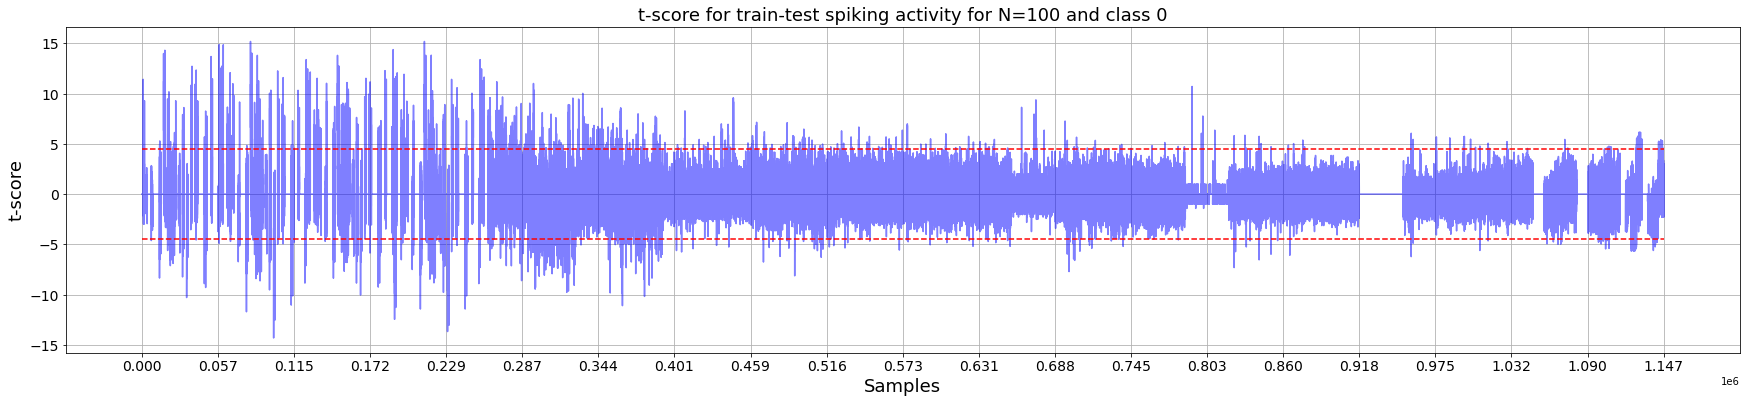

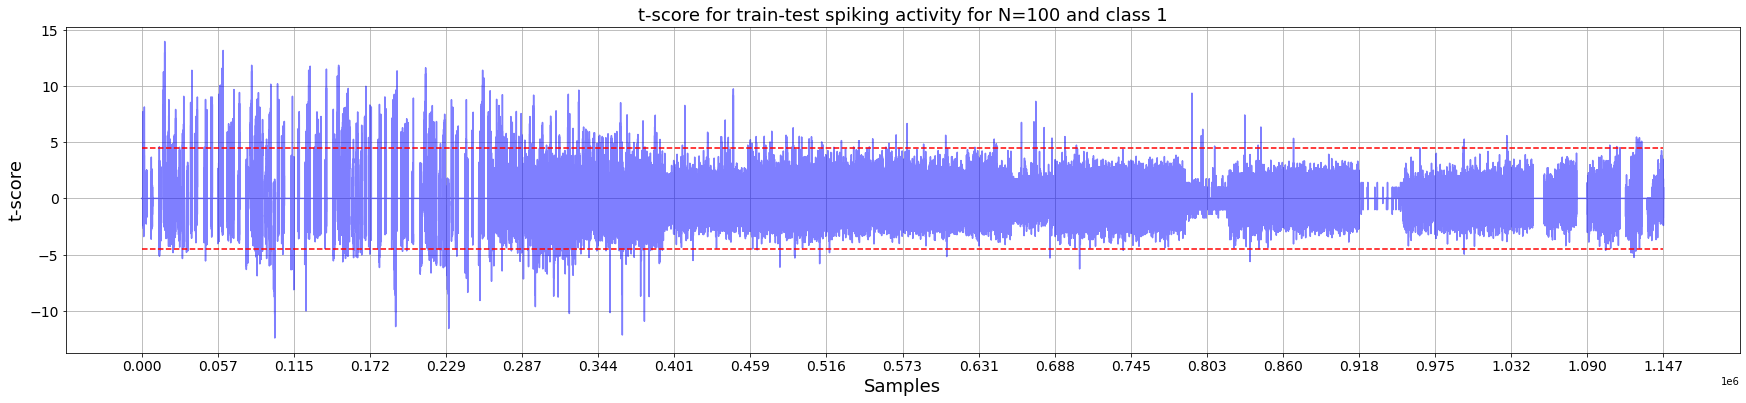

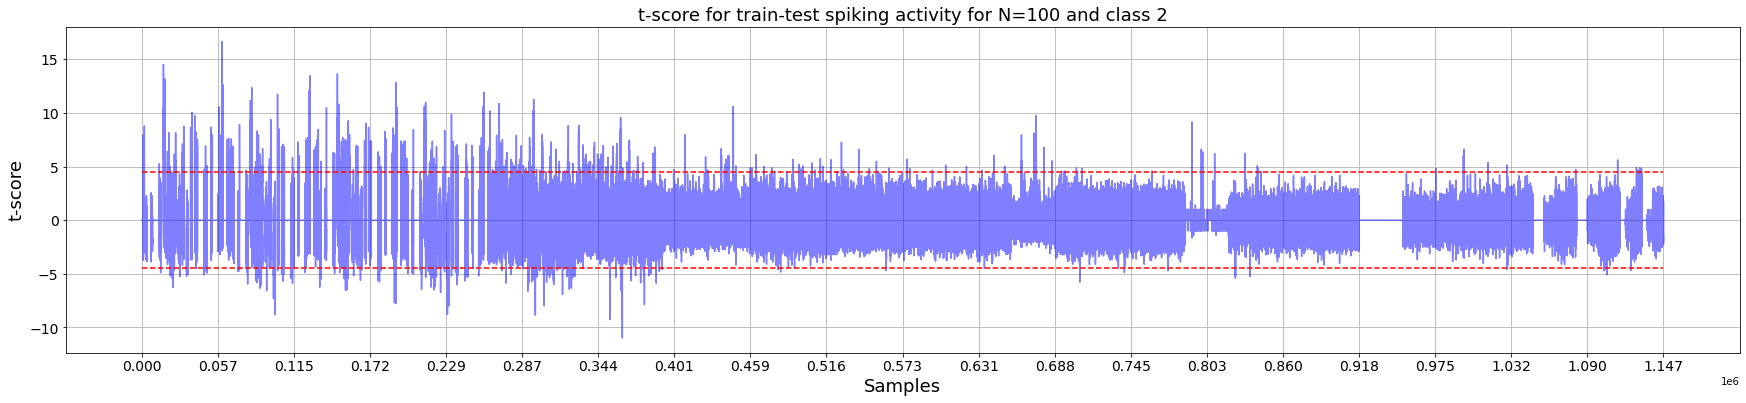

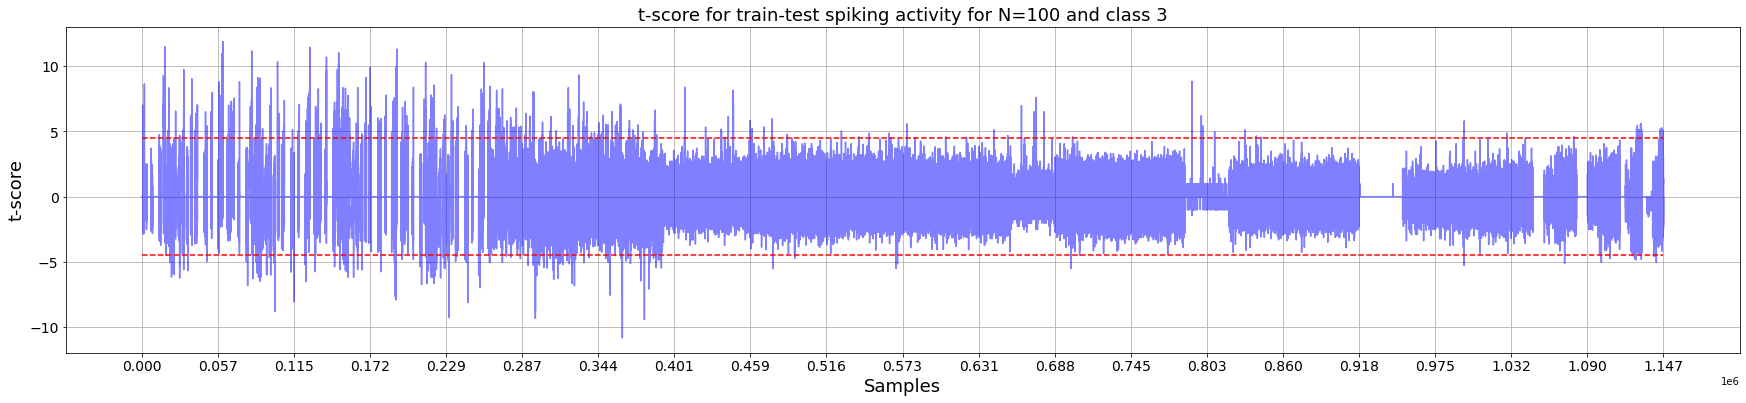

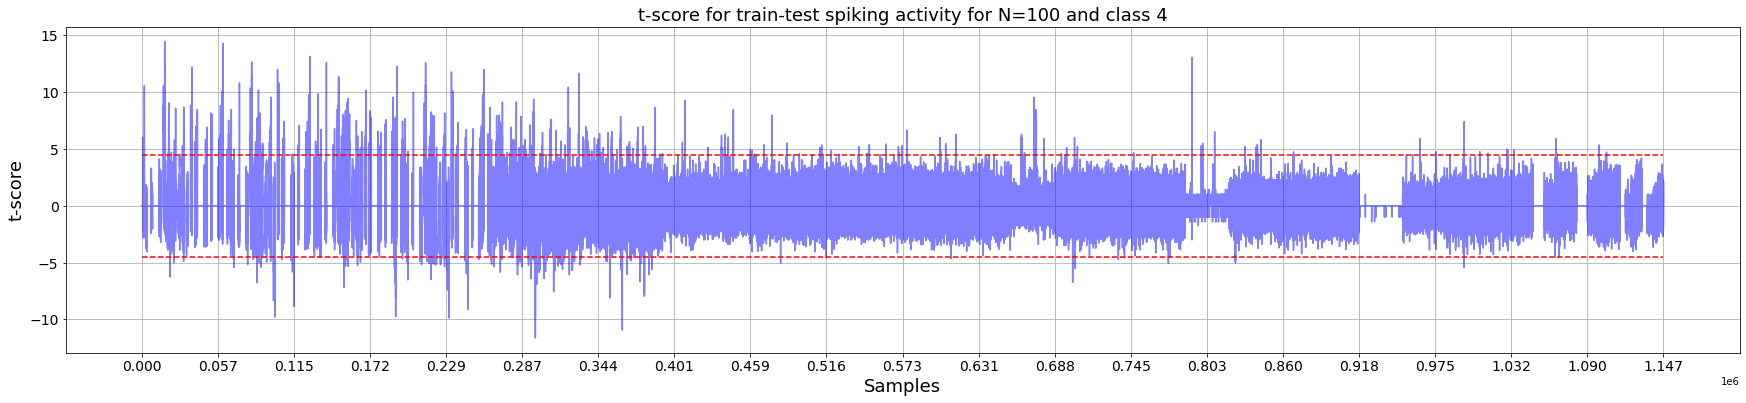

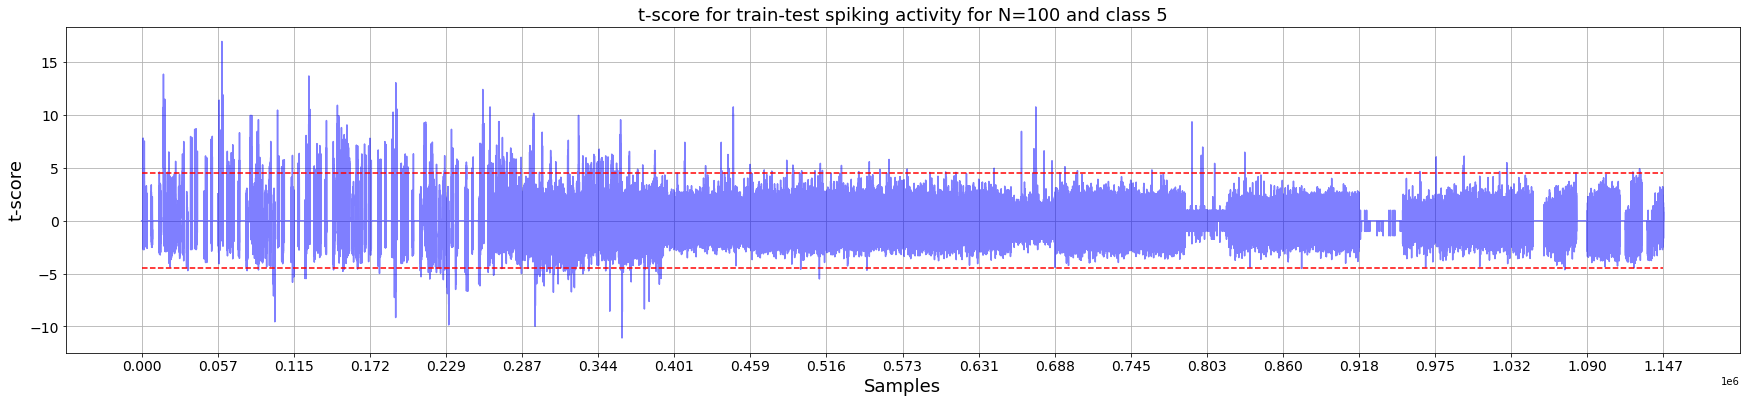

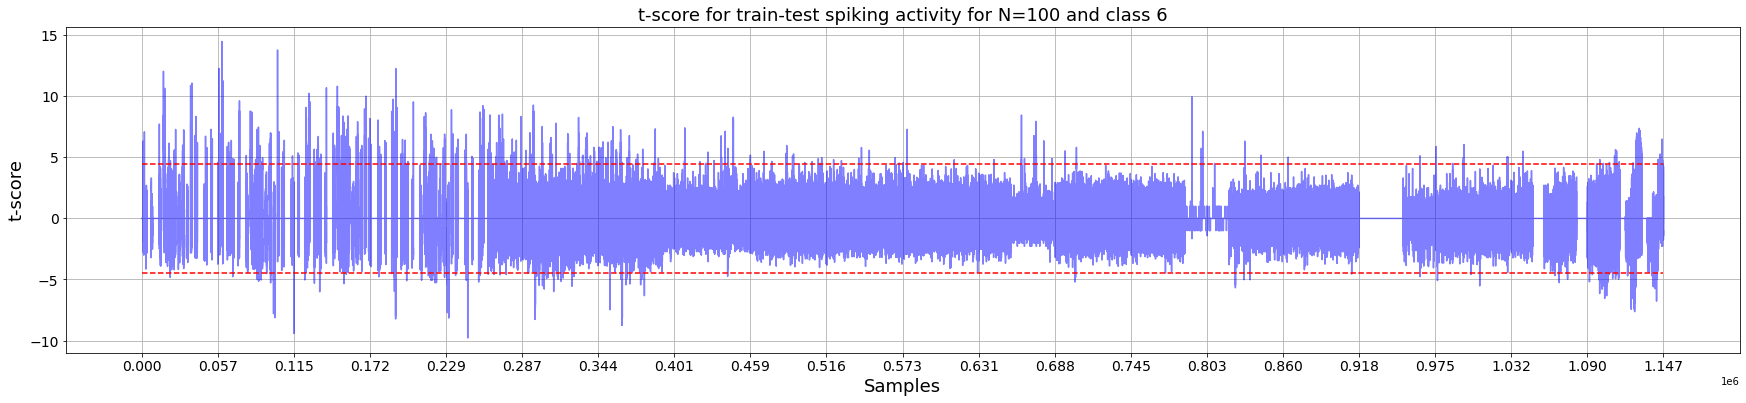

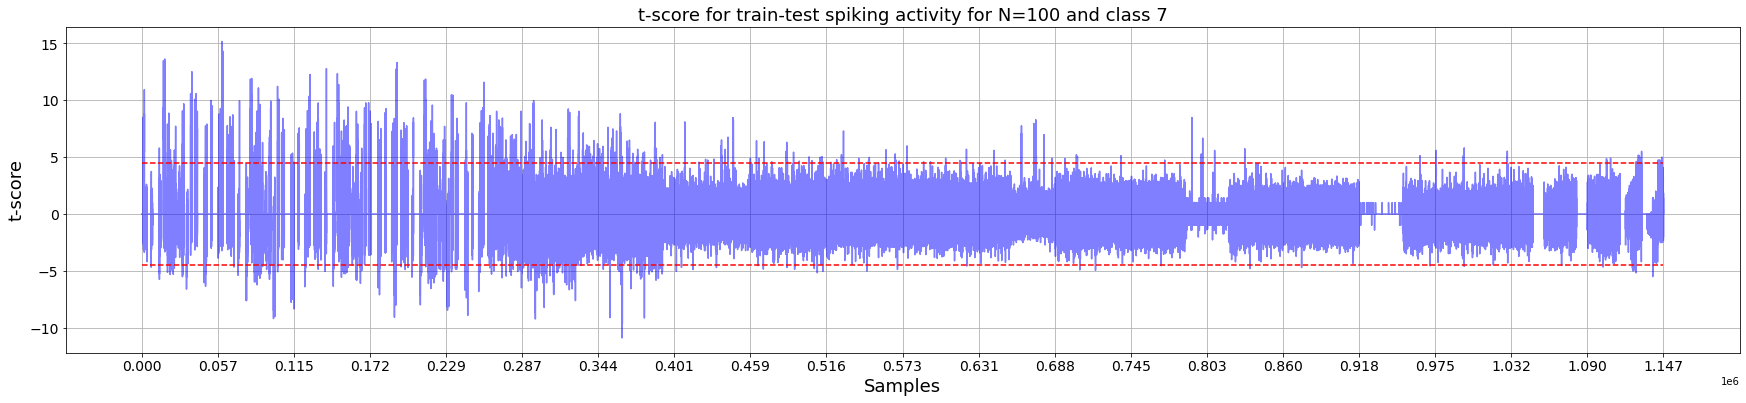

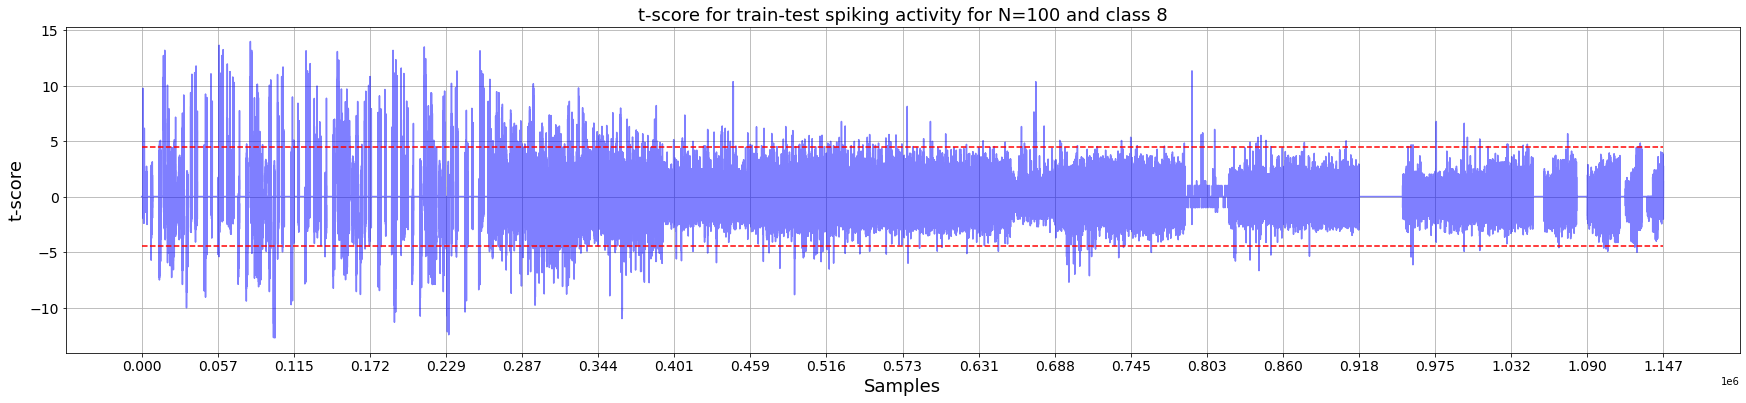

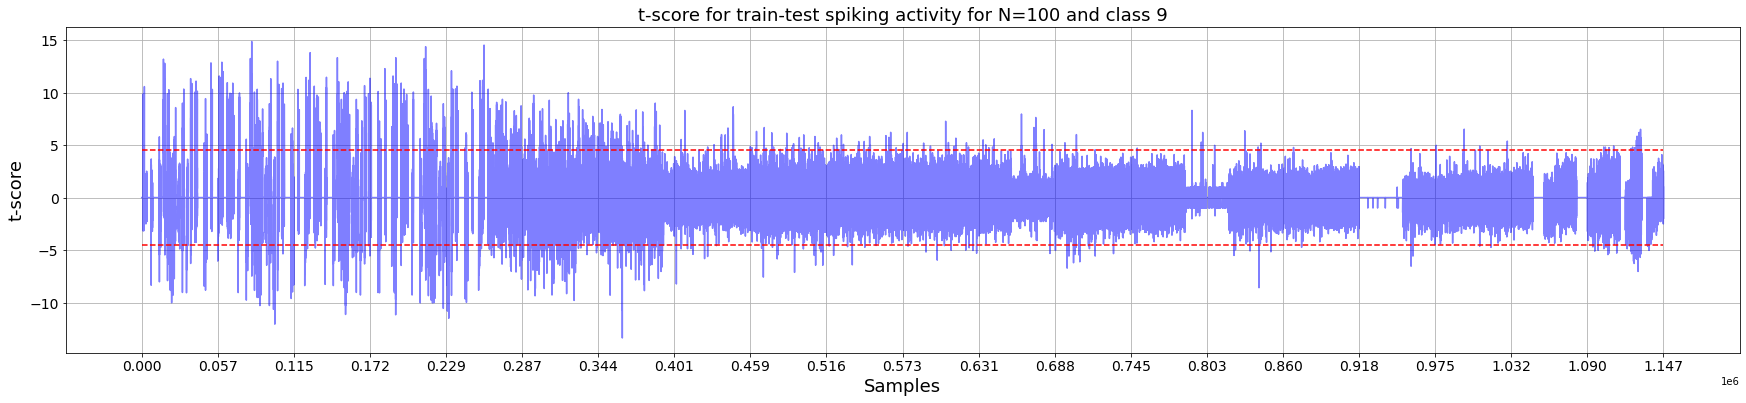

In [10]:
# split train_spikes and test_spikes on the basis of y_true and compute t-test
N=100
N_samples = train_spikes_class_idx[0].shape[1]

for class_idx in range(10):
    train_spikes = train_spikes_class_idx[class_idx]
    test_spikes = test_spikes_class_idx[class_idx]
    
    all_t_scores = []
    for i in range((N_samples//10000)+1):
        result, t_scores, leaky_points, large_p_values = compute_tvla(train_spikes[:N,i*10000:(i+1)*10000], test_spikes[:N,i*10000:(i+1)*10000])
        # print("t_scores: ", t_scores, "\nleaky_points: ", leaky_points, "\nlarge_p_values: ", large_p_values)
        all_t_scores.append(t_scores)

    print("----------------- class_idx: ", class_idx, "len(all_t_scores): ", len(all_t_scores))
    all_t_scores_arr = np.concatenate(all_t_scores)
    print(all_t_scores_arr.shape, N, train_spikes.shape[1])
    plot_tvla(all_t_scores_arr, N, 0, train_spikes.shape[1], class_idx)

#### t-test between Train and Train_adversarial spiking activity

In [4]:
# load spiking activity files
train_path = 'spikes_train/'
test_path = 'spikes_test/'
train_adv_path = 'spikes_train_Adv/'
test_adv_path = 'spikes_test_Adv/'
all_train_spikes = []
all_test_spikes = []
all_train_adv_spikes = []
all_test_adv_spikes = []

trainfiles = [f for f in listdir(train_path) if isfile(join(train_path, f))]
testfiles = [f for f in listdir(test_path) if isfile(join(test_path, f))]
train_adv_files = [f for f in listdir(train_adv_path) if isfile(join(train_adv_path, f))]
test_adv_files = [f for f in listdir(test_adv_path) if isfile(join(test_adv_path, f))]
print("Train files: ", len(trainfiles), "Test files: ", len(testfiles))
print("Train Adv files: ", len(train_adv_files), "Test Adv files: ", len(test_adv_files))

Train files:  196 Test files:  157
Train Adv files:  98 Test Adv files:  157


##### Load spiking activity traces

In [ ]:
df_train = pd.read_parquet(train_path + trainfiles[0])
df_test = pd.read_parquet(test_path + testfiles[0])
df_train_adv = pd.read_parquet(train_adv_path + train_adv_files[0])
df_test_adv = pd.read_parquet(test_adv_path + test_adv_files[0])
print("df_train.shape = ", df_train.shape, "df_test.shape = ", df_test.shape, "df_train_adv.shape = ", df_train_adv.shape, "df_test_adv.shape = ", df_test_adv.shape)

In [ ]:
train_spikes = []
test_spikes = []
train_y_true = []
test_y_true = []
train_adv_spikes = []
test_adv_spikes = []
train_adv_y_true = []
test_adv_y_true = []

for trainfile in trainfiles[:5]:
    # print(trainfile)
    df_train = pd.read_parquet(train_path + trainfile)
    for i in range(df_train['spikes'].shape[0]):
        train_spikes.append(df_train['spikes'][i])
        train_y_true.append(df_train['y_true'][i])

print("test files")
for testfile in testfiles[:19]:
    # print(testfile)
    df_test = pd.read_parquet(test_path + testfile)
    for i in range(df_test['spikes'].shape[0]):
        test_spikes.append(df_test['spikes'][i])
        test_y_true.append(df_test['y_true'][i])

print("train_adv files")
for train_adv_file in train_adv_files[:5]:
    df_train_adv = pd.read_parquet(train_adv_path + train_adv_file)
    for i in range(df_train_adv['spikes'].shape[0]):
        train_adv_spikes.append(df_train_adv['spikes'][i])
        train_adv_y_true.append(df_train_adv['y_true'][i])

print("test_adv files")
for test_adv_file in test_adv_files[:19]:
    df_test_adv = pd.read_parquet(test_adv_path + test_adv_file)
    for i in range(df_test_adv['spikes'].shape[0]):
        test_adv_spikes.append(df_test_adv['spikes'][i])
        test_adv_y_true.append(df_test_adv['y_true'][i])


train_spikes = np.array(train_spikes)
test_spikes = np.array(test_spikes)
train_y_true = np.array(train_y_true)
test_y_true = np.array(test_y_true)
train_adv_spikes = np.array(train_adv_spikes)
test_adv_spikes = np.array(test_adv_spikes)
train_adv_y_true = np.array(train_adv_y_true)
test_adv_y_true = np.array(test_adv_y_true)

print("train_spikes.shape = ", train_spikes.shape, "test_spikes.shape = ", test_spikes.shape)
print("train_y_true.shape = ", train_y_true.shape, "test_y_true.shape = ", test_y_true.shape)
print("train_adv_spikes.shape = ", train_adv_spikes.shape, "test_adv_spikes.shape = ", test_adv_spikes.shape)
print("train_adv_y_true.shape = ", train_adv_y_true.shape, "test_adv_y_true.shape = ", test_adv_y_true.shape)

##### Compute t-test between train and train_adv (class agnostic)

In [ ]:
def plot_adv_tvla(t_scores, N_traces, lower_bound, upper_bound, train_or_test_flag, class_idx=None):
    if class_idx is not None:
        # train_or_test_flag = True for train-train_adv spiking activity, 
        # False for test-test_adv spiking activity
        if train_or_test_flag: 
            plot_file_path = 'tvla_plots/t_trace_train_train_adv_spiking_activity_' + str(N_traces) + '_class_' + str(class_idx) + '.pdf'
        else:
            plot_file_path = 'tvla_plots/t_trace_test_test_adv_spiking_activity_' + str(N_traces) + '_class_' + str(class_idx) + '.pdf'
    else:
        if train_or_test_flag:
            plot_file_path = 'tvla_plots/t_trace_train_train_adv_spiking_activity_' + str(N_traces) + '.pdf'
        else:
            plot_file_path = 'tvla_plots/t_trace_test_test_adv_spiking_activity_' + str(N_traces) + '.pdf'
    number_of_samples = len(t_scores)
    instruction_index = np.arange(0, number_of_samples)
    
    f = plt.figure(figsize=(30,6));
    font = {'weight': 'normal','size': 18}
    plt.tight_layout()
    plt.xlabel('Samples', fontdict=font)
    plt.ylabel('t-score', fontdict=font)
    plt.xticks(np.arange(lower_bound, upper_bound+1, int(number_of_samples/20)), fontsize=14);
    plt.yticks(fontsize=14);
    plt.plot(instruction_index, (t_scores) ,color='blue', alpha=0.5) #, label = 'All registers')
    plt.plot([lower_bound, upper_bound+1],[4.5, 4.5], '--r')
    plt.plot([lower_bound, upper_bound+1],[-4.5, -4.5], '--r')

    plt.grid()
    # plt.legend(loc='lower left', fontsize=18)
    if class_idx is not None:
        if train_or_test_flag:
            plt.title ('t-score for train-train_adv spiking activity for N=' + str(N_traces) + ' and class ' + str(class_idx), fontdict=font)
        else:
            plt.title ('t-score for test-test_adv spiking activity for N=' + str(N_traces) + ' and class ' + str(class_idx), fontdict=font)
    else:
        if train_or_test_flag:
            plt.title ('t-score for train-train_adv spiking activity for N=' + str(N_traces), fontdict=font)
        else:
            plt.title ('t-score for test-test_adv spiking activity for N=' + str(N_traces), fontdict=font)
    plt.savefig(plot_file_path, bbox_inches = 'tight')

In [ ]:
N=1000
N_samples = train_spikes.shape[1]

# plot t-test results for train-train_adv spiking activity
all_t_scores = []
for i in range((N_samples//10000)+1):
    result, t_scores, leaky_points, large_p_values = compute_tvla(train_spikes[:N,i*10000:(i+1)*10000], train_adv_spikes[:N,i*10000:(i+1)*10000])
    # print("t_scores: ", t_scores, "\nleaky_points: ", leaky_points, "\nlarge_p_values: ", large_p_values)
    all_t_scores.append(t_scores)

print(len(all_t_scores))

# concatenate all_t_scores
all_t_scores_arr = np.concatenate(all_t_scores)
print(all_t_scores_arr.shape, N, train_spikes.shape[1])

# plot t-test results
plot_adv_tvla(all_t_scores_arr, N, 0, train_spikes.shape[1], True, None)

# plot t-test results for test-test_adv spiking activity
all_t_scores = []
for i in range((N_samples//10000)+1):
    result, t_scores, leaky_points, large_p_values = compute_tvla(test_spikes[:N,i*10000:(i+1)*10000], test_adv_spikes[:N,i*10000:(i+1)*10000])
    # print("t_scores: ", t_scores, "\nleaky_points: ", leaky_points, "\nlarge_p_values: ", large_p_values)
    all_t_scores.append(t_scores)

# concatenate all_t_scores
all_t_scores_arr = np.concatenate(all_t_scores)
print(all_t_scores_arr.shape, N, test_spikes.shape[1])

# plot t-test results
plot_adv_tvla(all_t_scores_arr, N, 0, test_spikes.shape[1], False, None)

##### KL Divergence

In [14]:
import numpy as np

def KL(a, b):
    a = np.asarray(a) #, dtype=np.float)
    b = np.asarray(b) #, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


values1 = [1.346112,1.337432,1.246655]
values2 = [1.033836,1.082015,1.117323]

print(KL(values1, values2))

0.7752796240788413
